First we import libraries

In [1]:
!pip install scikit-learn==0.22.2.post1
!pip install costcla


In [2]:
import joblib
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from costcla.metrics import cost_loss

from sklearn.calibration import CalibratedClassifierCV
from costcla.models import BayesMinimumRiskClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter


/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / function

We take the file and make a dataframe

In [3]:
heartArray = np.loadtxt('heart.dat', unpack = True)
columns = ['age ','sex','cpt', 'rbp', 'sc', 'fbs', 
                                         'rer', 'mhr', 'eia', 'oldpeak', 'slope', 
                                         'nmv', 'thal', 'presence']
df = pd.DataFrame(heartArray.transpose(1, 0), columns = columns)

In [4]:
print(df)

     age   sex  cpt    rbp     sc  fbs  rer    mhr  eia  oldpeak  slope  nmv  \
0    70.0  1.0  4.0  130.0  322.0  0.0  2.0  109.0  0.0      2.4    2.0  3.0   
1    67.0  0.0  3.0  115.0  564.0  0.0  2.0  160.0  0.0      1.6    2.0  0.0   
2    57.0  1.0  2.0  124.0  261.0  0.0  0.0  141.0  0.0      0.3    1.0  0.0   
3    64.0  1.0  4.0  128.0  263.0  0.0  0.0  105.0  1.0      0.2    2.0  1.0   
4    74.0  0.0  2.0  120.0  269.0  0.0  2.0  121.0  1.0      0.2    1.0  1.0   
..    ...  ...  ...    ...    ...  ...  ...    ...  ...      ...    ...  ...   
265  52.0  1.0  3.0  172.0  199.0  1.0  0.0  162.0  0.0      0.5    1.0  0.0   
266  44.0  1.0  2.0  120.0  263.0  0.0  0.0  173.0  0.0      0.0    1.0  0.0   
267  56.0  0.0  2.0  140.0  294.0  0.0  2.0  153.0  0.0      1.3    2.0  0.0   
268  57.0  1.0  4.0  140.0  192.0  0.0  0.0  148.0  0.0      0.4    2.0  0.0   
269  67.0  1.0  4.0  160.0  286.0  0.0  2.0  108.0  1.0      1.5    2.0  3.0   

     thal  presence  
0     3.0       2

Now we have to check for missing values

With heart disease: 120
Without heart disease: 150
Percentages with and without heart disease: 44.44444444444444 55.55555555555556


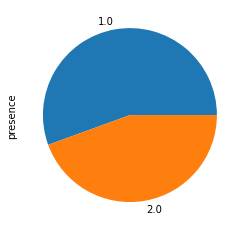

In [5]:
with_hd = (df.presence == 2)
without_hd = (df.presence == 1)
print("With heart disease:",with_hd.sum())
print("Without heart disease:",without_hd.sum())

df['presence'].value_counts().plot(kind='pie')
print("Percentages with and without heart disease:",with_hd.sum()*100/len(df),without_hd.sum()*100/len(df))


We have about half from each type which is very good for classification.

Now we have to drop unnecessary columns.
Attribute Information:
------------------------
1. age
2. sex
3. chest pain type (4 values) [cpt]
4. resting blood pressure [rbp]
5. serum cholesterol in mg/dl [sc]
6. fasting blood sugar > 120 mg/dl [fbs]
7. resting electrocardiographic results (values 0,1,2) [rer]
8. maximum heart rate achieved [mhr]
9. exercise induced angina [eia]
10. oldpeak = ST depression induced by exercise relative to rest [oldpeak]
11. the slope of the peak exercise ST segment [slope]
12. number of major vessels (0-3) colored by flourosopy [nmv]
13. thal: 3 = normal; 6 = fixed defect; 7 = reversable defect [thal] 

In [6]:
df.drop(columns=["presence"]).describe()

,age,sex,cpt,rbp,sc,fbs,rer,mhr,eia,oldpeak,slope,nmv,thal
count,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.00000,270.000000,270.000000,270.000000
mean,54.433333,0.677778,3.174074,131.344444,249.659259,0.148148,1.022222,149.677778,0.329630,1.05000,1.585185,0.670370,4.696296
std,9.109067,0.468195,0.950090,17.861608,51.686237,0.355906,0.997891,23.165717,0.470952,1.14521,0.614390,0.943896,1.940659
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.00000,1.000000,0.000000,3.000000
25%,48.000000,0.000000,3.000000,120.000000,213.000000,0.000000,0.000000,133.000000,0.000000,0.00000,1.000000,0.000000,3.000000
50%,55.000000,1.000000,3.000000,130.000000,245.000000,0.000000,2.000000,153.500000,0.000000,0.80000,2.000000,0.000000,3.000000
75%,61.000000,1.000000,4.000000,140.000000,280.000000,0.000000,2.000000,166.000000,1.000000,1.60000,2.000000,1.000000,7.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.20000,3.000000,3.000000,7.000000


At first glance every column semms imporant. The two we might be able to remove are 
1. sex
2. age

Age according to this link 

(https://memorialhermann.org/services/specialties/heart-and-vascular/healthy-living/education/heart-disease-and-age) 

plays an important role in heart disease.

"Your risk for heart disease increases with age, especially with people of color and for those who are over 65. While the average age for a heart attack is 64.5 for men, and 70.3 for women, nearly 20 percent of those who die of heart disease are under the age of 65."

Also from the same link we can see that the average age for men and women are different but we could not find any indicator that plays an important role for a specific gender from the other columns. Men might have a higher resting blood pressure than women for example but if we do not know if that means that there is a higher chance for heart disease. We cannot remove anything based on these alone so we have to check for correlation

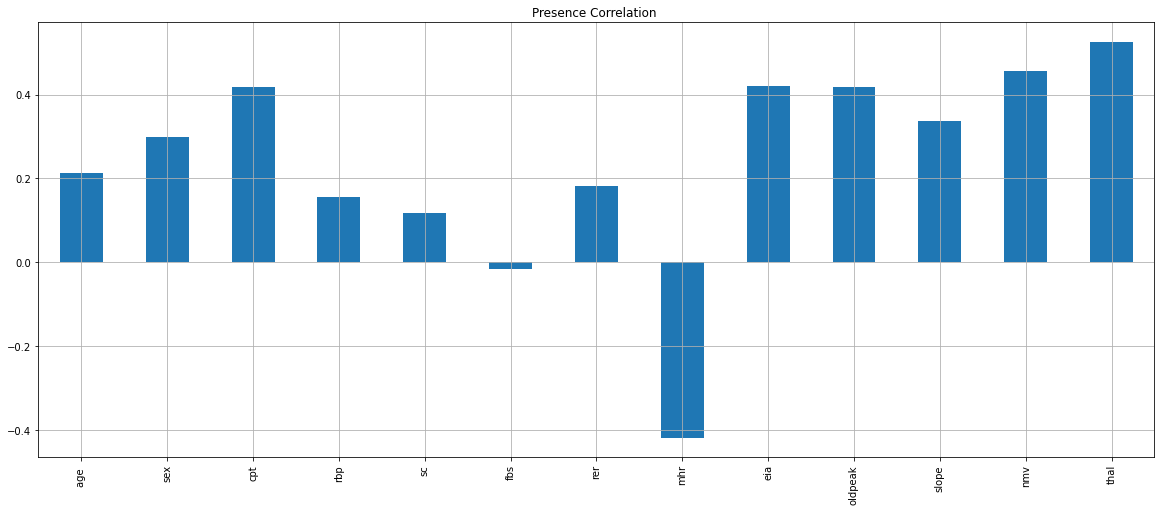

In [7]:
df.drop(columns=["presence"]).corrwith(df.presence).plot(kind='bar', grid=True, figsize=(20, 8), title="Presence Correlation ")

The least correlated column is fbs so we can drop it.

In [8]:
dfx = df.drop(columns=["fbs"])

Adding the cost matrix

**Cost Matrix**

| | absence | presence|
|-|-------- |:--------|
|absence| 0 | 1|
|presence|5|0|

_______ 

> Where the rows represent the true values and the columns the predicted. 
______

In [9]:
cost_matrix = [[0 , 1], [5, 0]]

In [10]:
y = dfx["presence"].values

y[y == 1] = 0
y[y == 2] = 1

X_train, X_test, y_train, y_test = train_test_split(dfx.drop(columns=["presence"]).values, 
                                                    dfx["presence"].values, test_size=0.3, 
                                                    random_state=0)


In [11]:
names = ['Random Forest', 'Linear SVM','Naive Bayes']
classifiers = [RandomForestClassifier(n_estimators=100, random_state=0), 
               SVC(kernel='linear', C=10),
               GaussianNB()]

In [12]:
for name, clf in zip(names, classifiers):
  print("\033[4m" +  name + "\033[0m")
  print("------------------------------------------------------")

  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(classification_report(y_test, y_pred, target_names=['absence','presence']))

  conf_m = confusion_matrix(y_test, y_pred,)
  print("\033[4m" + "Confusion matrix" + "\033[0m")
  print(conf_m , "\n") 
  loss = np.sum(conf_m * cost_matrix)
  print("loss: %d" %loss)
  print("------------------------------------------------------\n")


Random Forest
------------------------------------------------------
              precision    recall  f1-score   support

     absence       0.88      0.79      0.84        48
    presence       0.74      0.85      0.79        33

    accuracy                           0.81        81
   macro avg       0.81      0.82      0.81        81
weighted avg       0.82      0.81      0.82        81

Confusion matrix
[[38 10]
 [ 5 28]] 

loss: 35
------------------------------------------------------

Linear SVM
------------------------------------------------------
              precision    recall  f1-score   support

     absence       0.87      0.83      0.85        48
    presence       0.77      0.82      0.79        33

    accuracy                           0.83        81
   macro avg       0.82      0.83      0.82        81
weighted avg       0.83      0.83      0.83        81

Confusion matrix
[[40  8]
 [ 6 27]] 

loss: 38
------------------------------------------------------

Naive

We can see that between Random Forest, Linear SVM and Naive Bayes, the lowest cost is represented by the Random Forest algorithm which is 35. It is followed by Linear SVM with cost 38 and finally, as expected, Naive Bayes has the biggest one which is 45. In terms of accuracy, Linear SVM has the highest but we are now focusing only on the cost each algorithm represents.


**Calibration**

Cost matrix required for BayesMinimumRiskClassifier and costcla

In [13]:
fp = np.full((y_test.shape[0],1), 1)
fn = np.full((y_test.shape[0],1), 5)
tp = np.zeros((y_test.shape[0],1))
tn = np.zeros((y_test.shape[0],1))
cost_matrix = np.hstack((fp, fn, tp, tn))

*No calibration*

In [14]:
names = ['Random Forest', 'Linear SVM','Naive Bayes']
classifiers = [RandomForestClassifier(n_estimators=100, random_state=0), 
               SVC(kernel='linear', C=10,probability=True),
               GaussianNB()]

In [15]:
for name, clf in zip(names, classifiers):
  print("\033[4m" +  name + "\033[0m")
  print("------------------------------------------------------")

  clf.fit(X_train, y_train)
  y_pred_proba = clf.predict_proba(X_test)

  bmr = BayesMinimumRiskClassifier(calibration=False)

  y_pred = bmr.predict(y_pred_proba, cost_matrix)
  
  print(classification_report(y_test, y_pred, target_names=['absence','presence']))

  conf_m = confusion_matrix(y_test, y_pred)
  print("\033[4m" + "Confusion matrix" + "\033[0m")
  print(conf_m , "\n") 
  loss = cost_loss(y_test, y_pred, cost_matrix)
  print("loss: %d" %loss)
  print("------------------------------------------------------\n")


Random Forest
------------------------------------------------------
              precision    recall  f1-score   support

     absence       1.00      0.29      0.45        48
    presence       0.49      1.00      0.66        33

    accuracy                           0.58        81
   macro avg       0.75      0.65      0.56        81
weighted avg       0.79      0.58      0.54        81

Confusion matrix
[[14 34]
 [ 0 33]] 

loss: 34
------------------------------------------------------

Linear SVM
------------------------------------------------------
              precision    recall  f1-score   support

     absence       0.92      0.23      0.37        48
    presence       0.46      0.97      0.63        33

    accuracy                           0.53        81
   macro avg       0.69      0.60      0.50        81
weighted avg       0.73      0.53      0.47        81

Confusion matrix
[[11 37]
 [ 1 32]] 

loss: 42
------------------------------------------------------

Naive

After applying Bayes Minimum Risk Classifier with no callibration, average cost seems to be slightly less but with no significant impact to the model.  

*costcla calibration on training set*

In [16]:
for name, clf in zip(names, classifiers):
  print("\033[4m" +  name + "\033[0m")
  print("------------------------------------------------------")

  clf.fit(X_train, y_train)
  train_proba = clf.predict_proba(X_train)

  bmr = BayesMinimumRiskClassifier(calibration=True)
  bmr.fit(y_train, train_proba) 

  y_pred_proba = clf.predict_proba(X_test)
  y_pred = bmr.predict(y_pred_proba, cost_matrix)

  print(classification_report(y_test, y_pred,zero_division=0,target_names=['absence','presence']))

  conf_m = confusion_matrix(y_test, y_pred)
  print("\033[4m" + "Confusion matrix" + "\033[0m")
  print(conf_m , "\n") 
  loss = cost_loss(y_test, y_pred, cost_matrix)
  print("loss: %d" %loss)
  print("------------------------------------------------------\n")


Random Forest
------------------------------------------------------
              precision    recall  f1-score   support

     absence       0.85      0.85      0.85        48
    presence       0.79      0.79      0.79        33

    accuracy                           0.83        81
   macro avg       0.82      0.82      0.82        81
weighted avg       0.83      0.83      0.83        81

Confusion matrix
[[41  7]
 [ 7 26]] 

loss: 42
------------------------------------------------------

Linear SVM
------------------------------------------------------
              precision    recall  f1-score   support

     absence       0.96      0.48      0.64        48
    presence       0.56      0.97      0.71        33

    accuracy                           0.68        81
   macro avg       0.76      0.72      0.68        81
weighted avg       0.80      0.68      0.67        81

Confusion matrix
[[23 25]
 [ 1 32]] 

loss: 30
------------------------------------------------------

Naive

After applying Bayes Minimum Risk Classifier with callibration, we see a better performance of the model in terms of cost at L-SVM and Naive Bayes whose cost is now downgrated from 38 to 30 and from 45 to 39 respectively. On the other hand, Random Forest represents  raised cost which went from 35 to 42

Sigmoid and Isotonic Calibration with cv 3


In [17]:
calibrations = ['sigmoid','isotonic']

for calibration in calibrations:
  print("\033[4m" +  calibration + "\033[0m")
  print("=======================================================================")
  for name, clf in zip(names, classifiers):
    print("\033[4m" +  name + "\033[0m")
    print("------------------------------------------------------")

    cc = CalibratedClassifierCV(clf, method=calibration, cv=3)
    model = cc.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)
    bmr = BayesMinimumRiskClassifier(calibration=False)
    y_pred = bmr.predict(y_pred_proba, cost_matrix)

    print(classification_report(y_test, y_pred,zero_division=0,target_names=['absence','presence']))

    conf_m = confusion_matrix(y_test, y_pred)
    print("\033[4m" + "Confusion matrix" + "\033[0m")
    print(conf_m , "\n") 
    loss = cost_loss(y_test, y_pred, cost_matrix)
    print("loss: %d" %loss)
    print("------------------------------------------------------\n")
  print("=======================================================================")



sigmoid
Random Forest
------------------------------------------------------
              precision    recall  f1-score   support

     absence       1.00      0.29      0.45        48
    presence       0.49      1.00      0.66        33

    accuracy                           0.58        81
   macro avg       0.75      0.65      0.56        81
weighted avg       0.79      0.58      0.54        81

Confusion matrix
[[14 34]
 [ 0 33]] 

loss: 34
------------------------------------------------------

Linear SVM
------------------------------------------------------
              precision    recall  f1-score   support

     absence       0.94      0.35      0.52        48
    presence       0.51      0.97      0.67        33

    accuracy                           0.60        81
   macro avg       0.73      0.66      0.59        81
weighted avg       0.77      0.60      0.58        81

Confusion matrix
[[17 31]
 [ 1 32]] 

loss: 36
-----------------------------------------------------

test other cv

In [18]:
calibrations = ['sigmoid','isotonic']

for calibration in calibrations:
  print("\033[4m" +  calibration + "\033[0m")
  print("=======================================================================")
  for name, clf in zip(names, classifiers):
    print("\033[4m" +  name + "\033[0m")
    print("------------------------------------------------------")

    cc = CalibratedClassifierCV(clf, method=calibration, cv=10)
    model = cc.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)
    bmr = BayesMinimumRiskClassifier(calibration=False)
    y_pred = bmr.predict(y_pred_proba, cost_matrix)

    print(classification_report(y_test, y_pred,zero_division=0,target_names=['absence','presence']))

    conf_m = confusion_matrix(y_test, y_pred)
    print("\033[4m" + "Confusion matrix" + "\033[0m")
    print(conf_m , "\n") 
    loss = cost_loss(y_test, y_pred, cost_matrix)
    print("loss: %d" %loss)
    print("------------------------------------------------------\n")
  print("=======================================================================")



sigmoid
Random Forest
------------------------------------------------------
              precision    recall  f1-score   support

     absence       1.00      0.23      0.37        48
    presence       0.47      1.00      0.64        33

    accuracy                           0.54        81
   macro avg       0.74      0.61      0.51        81
weighted avg       0.78      0.54      0.48        81

Confusion matrix
[[11 37]
 [ 0 33]] 

loss: 37
------------------------------------------------------

Linear SVM
------------------------------------------------------
              precision    recall  f1-score   support

     absence       0.89      0.17      0.28        48
    presence       0.44      0.97      0.61        33

    accuracy                           0.49        81
   macro avg       0.67      0.57      0.45        81
weighted avg       0.71      0.49      0.41        81

Confusion matrix
[[ 8 40]
 [ 1 32]] 

loss: 45
-----------------------------------------------------

In [19]:
calibrations = ['sigmoid','isotonic']

for calibration in calibrations:
  print("\033[4m" +  calibration + "\033[0m")
  print("=======================================================================")
  for name, clf in zip(names, classifiers):
    print("\033[4m" +  name + "\033[0m")
    print("------------------------------------------------------")

    cc = CalibratedClassifierCV(clf, method=calibration, cv=11)
    model = cc.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)
    bmr = BayesMinimumRiskClassifier(calibration=False)
    y_pred = bmr.predict(y_pred_proba, cost_matrix)

    print(classification_report(y_test, y_pred,zero_division=0,target_names=['absence','presence']))

    conf_m = confusion_matrix(y_test, y_pred)
    print("\033[4m" + "Confusion matrix" + "\033[0m")
    print(conf_m , "\n") 
    loss = cost_loss(y_test, y_pred, cost_matrix)
    print("loss: %d" %loss)
    print("------------------------------------------------------\n")
  print("=======================================================================")



sigmoid
Random Forest
------------------------------------------------------
              precision    recall  f1-score   support

     absence       1.00      0.19      0.32        48
    presence       0.46      1.00      0.63        33

    accuracy                           0.52        81
   macro avg       0.73      0.59      0.47        81
weighted avg       0.78      0.52      0.44        81

Confusion matrix
[[ 9 39]
 [ 0 33]] 

loss: 39
------------------------------------------------------

Linear SVM
------------------------------------------------------
              precision    recall  f1-score   support

     absence       0.86      0.12      0.22        48
    presence       0.43      0.97      0.60        33

    accuracy                           0.47        81
   macro avg       0.64      0.55      0.41        81
weighted avg       0.68      0.47      0.37        81

Confusion matrix
[[ 6 42]
 [ 1 32]] 

loss: 47
-----------------------------------------------------

After apllying Isotonic callibration, the results are overall better. The sigmoid did not yield good results for some reason. One reason might be that the dataset is small.

Also note the with the Linear SVM the sigmoid callibration is worse than the other models, which is strange because the sigmoid calibration tends to work well with Linear SVMs.


**The first part of the project continues on the project-A2.ipynb**